In [2]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime as dt

In [3]:
# Pre-processing

# Import data
file_name = "../datasets/air-quality-uci/AirQualityUCI.csv"
df = pd.read_csv(file_name, sep=';',  parse_dates=[['Date', 'Time']])

# Clean-up column names
df.columns = df.columns.str.replace('(', '_').str.replace(')', '')

# Drop empty rows at the end
df = df[:-114] 

# Drop empty columns at the end
df = df.drop(df.columns[14:16], axis=1)

# Fix commas in column values and column data types
df['CO_GT'] = pd.to_numeric(df['CO_GT'].str.replace(',', '.'))
df['C6H6_GT'] =  pd.to_numeric(df['C6H6_GT'].str.replace(',', '.'))
df['T'] = pd.to_numeric(df['T'].str.replace(',', '.'))
df['RH'] = pd.to_numeric(df['RH'].str.replace(',', '.'))
df['AH'] = pd.to_numeric(df['AH'].str.replace(',', '.'))

# Fix date time column and set as index
df['Date_Time'] = pd.to_datetime(df.Date_Time, format='%d/%m/%Y %H.%M.%S')
df['Date'] = pd.to_datetime(df.Date_Time, format='%d/%m/%Y')
df['Date'] = df['Date'].dt.normalize()

df = df.set_index('Date_Time')

# Reorder columns
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

# Missing values are encoded as -200 in the dataset, replace them with NaN
df = df.replace(-200, np.NaN)


In [5]:
df.columns

Index(['Date', 'CO_GT', 'PT08.S1_CO', 'NMHC_GT', 'C6H6_GT', 'PT08.S2_NMHC',
       'NOx_GT', 'PT08.S3_NOx', 'NO2_GT', 'PT08.S4_NO2', 'PT08.S5_O3', 'T',
       'RH', 'AH'],
      dtype='object')

In [6]:
features = ['PT08.S1_CO', 'PT08.S2_NMHC','PT08.S3_NOx', 'PT08.S4_NO2', 'PT08.S5_O3','T','RH', 'AH']
targets = ['CO_GT', 'C6H6_GT', 'NOx_GT', 'NO2_GT']

In [7]:
# Fill missing values with daily averages
grouped = df[features].groupby(df.Date).mean()
grouped = grouped.fillna(method='ffill')

for f in features:
    df[f].fillna(df.Date.map(grouped[f]), inplace=True)

In [56]:
# Detect outliers based on z-score
for f in features:
    z = np.abs(stats.zscore(df[f]))
    print(f, ": ", df[f][(z > 3)].count())


PT08.S1_CO :  65
PT08.S2_NMHC :  40
PT08.S3_NOx :  112
PT08.S4_NO2 :  43
PT08.S5_O3 :  37
T :  0
RH :  0
AH :  1


In [57]:
# Detect outliers based on inter-quartile range
for f in features:
    Q1 = df[f].quantile(0.25)
    Q3 = df[f].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[f][(df[f] < (Q1 - 1.5 * IQR)) | (df[f] > (Q3 + 1.5 * IQR))].count()
    print(f, ": ", outliers)

PT08.S1_CO :  131
PT08.S2_NMHC :  61
PT08.S3_NOx :  252
PT08.S4_NO2 :  112
PT08.S5_O3 :  95
T :  2
RH :  0
AH :  1


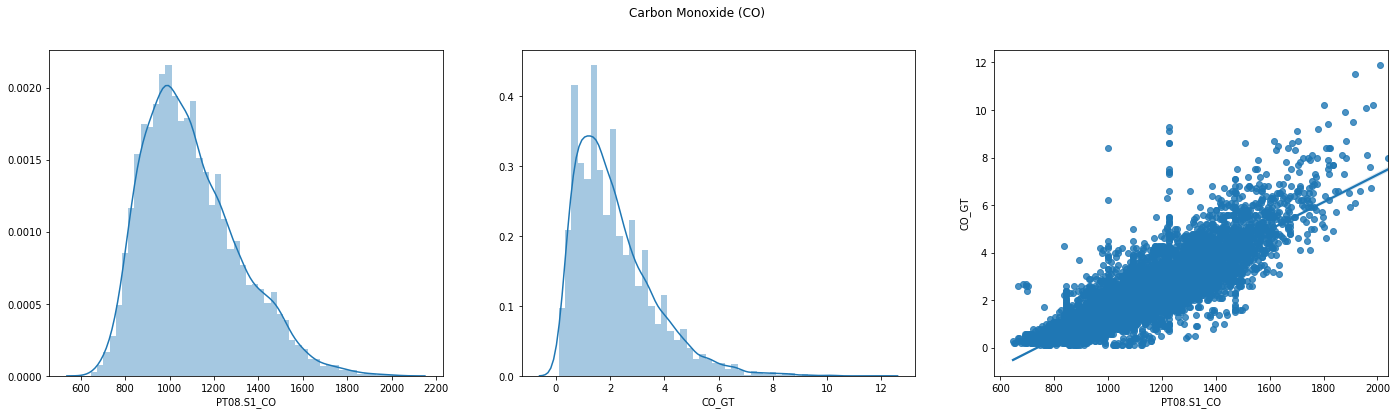

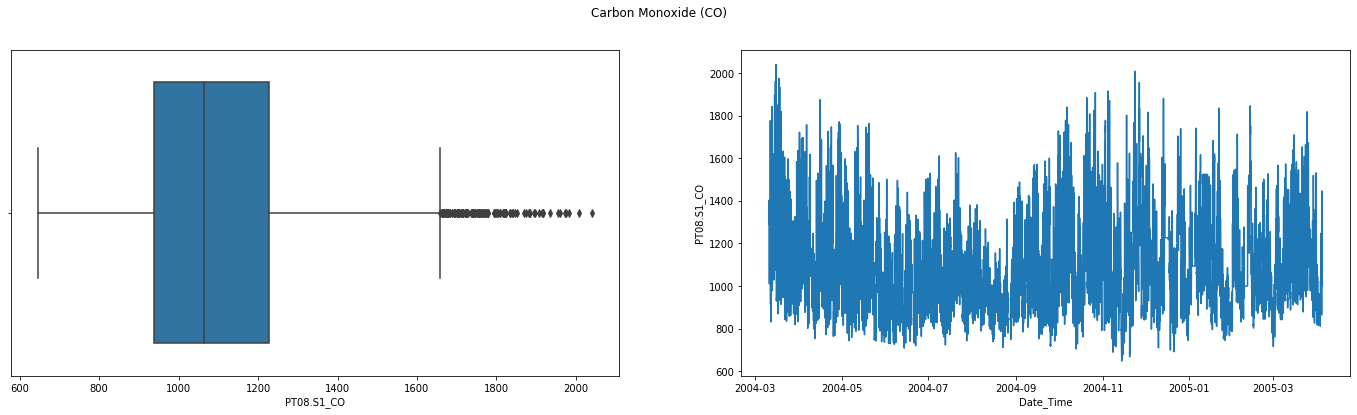

In [13]:
# Carbon Monoxide (CO) data
fig, (ax1,ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle('Carbon Monoxide (CO)')
sns.distplot(df['PT08.S1_CO'], norm_hist=False, kde=True, ax=ax1) 
sns.distplot(df['CO_GT'], norm_hist=False, kde=True, ax=ax2)   
sns.regplot(x="PT08.S1_CO", y="CO_GT", data=df, ax=ax3)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
fig.suptitle('Carbon Monoxide (CO)')
sns.boxplot(x="PT08.S1_CO", data=df, ax=ax1)
sns.lineplot(x=df.index, y="PT08.S1_CO", data=df, ax=ax2)

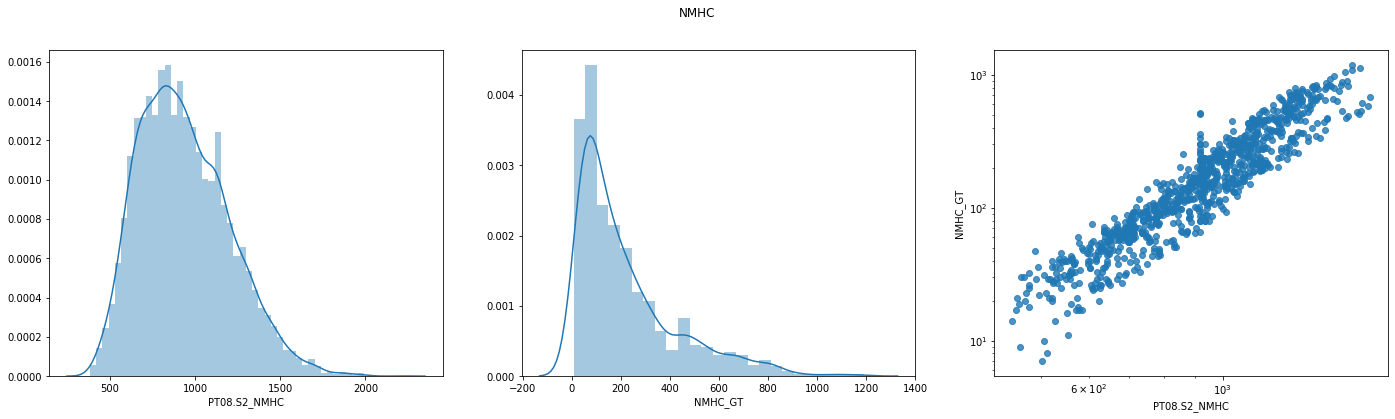

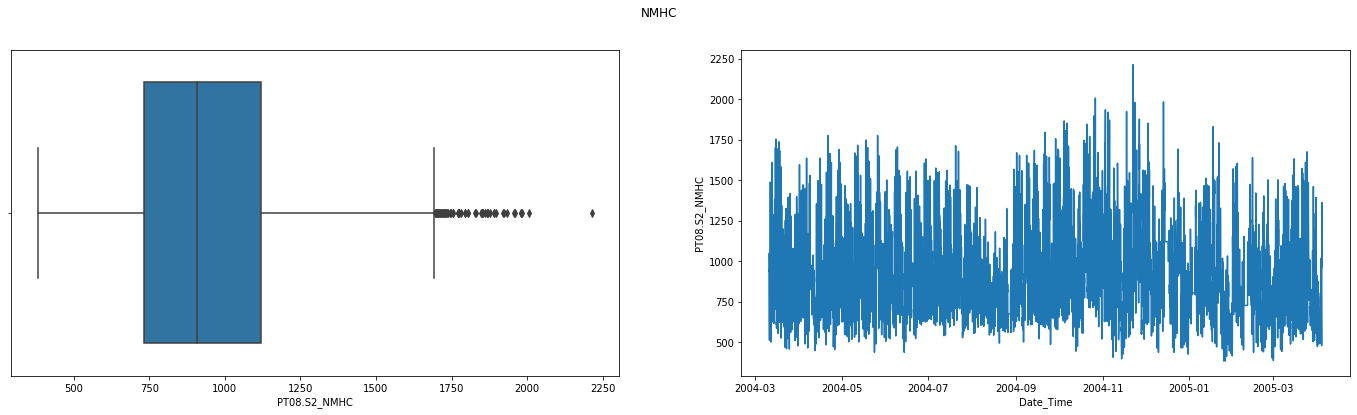

In [11]:
# Non-Methane Hydrocarbons data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle('NMHC')
sns.distplot(df['PT08.S2_NMHC'], norm_hist=False, kde=True, ax=ax1) 
sns.distplot(df['NMHC_GT'], norm_hist=False, kde=True, ax=ax2)   
sns.regplot(x="PT08.S2_NMHC", y="NMHC_GT", fit_reg=False, data=df, ax=ax3)
ax3.set(xscale='log', yscale='log')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
fig.suptitle('NMHC')
sns.boxplot(x="PT08.S2_NMHC", data=df, ax=ax1)
sns.lineplot(x=df.index, y="PT08.S2_NMHC", data=df, ax=ax2)

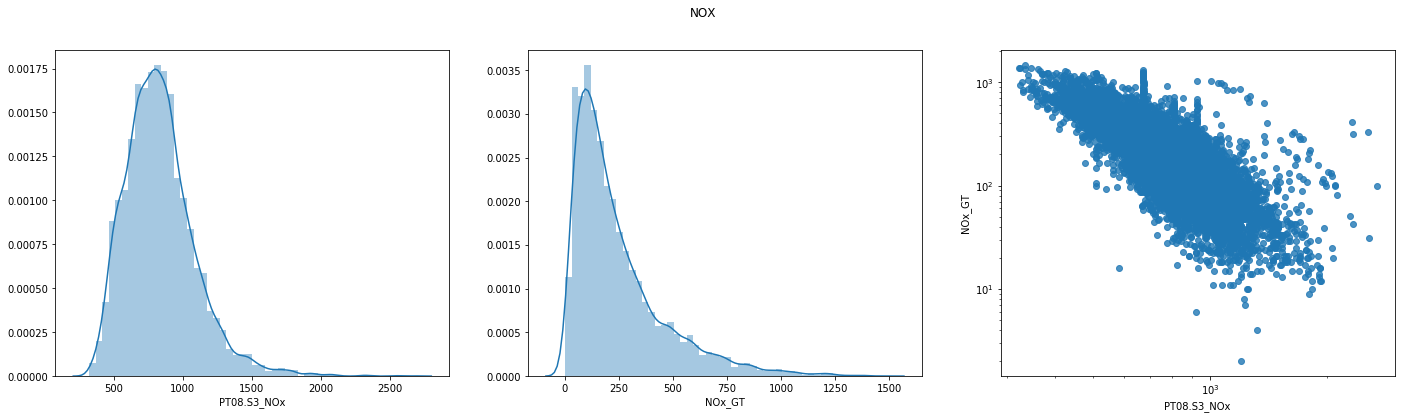

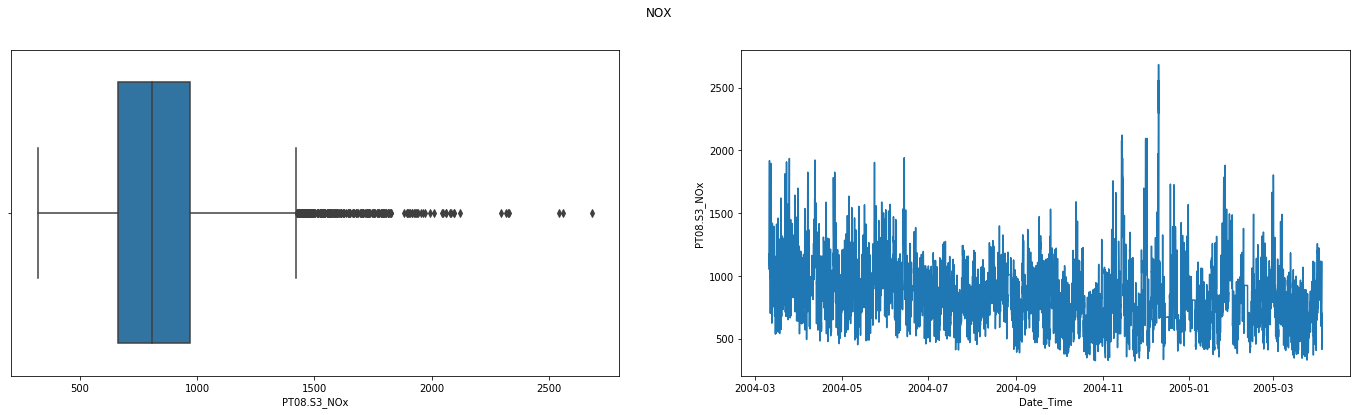

In [14]:
# NOX data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle('NOX')
sns.distplot(df['PT08.S3_NOx'], norm_hist=False, kde=True, ax=ax1) 
sns.distplot(df['NOx_GT'], norm_hist=False, kde=True, ax=ax2)   
sns.regplot(x="PT08.S3_NOx", y="NOx_GT", fit_reg=False, data=df, ax=ax3)
ax3.set(xscale='log', yscale='log')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
fig.suptitle('NOX')
sns.boxplot(x="PT08.S3_NOx", data=df, ax=ax1)
sns.lineplot(x=df.index, y="PT08.S3_NOx", data=df, ax=ax2)

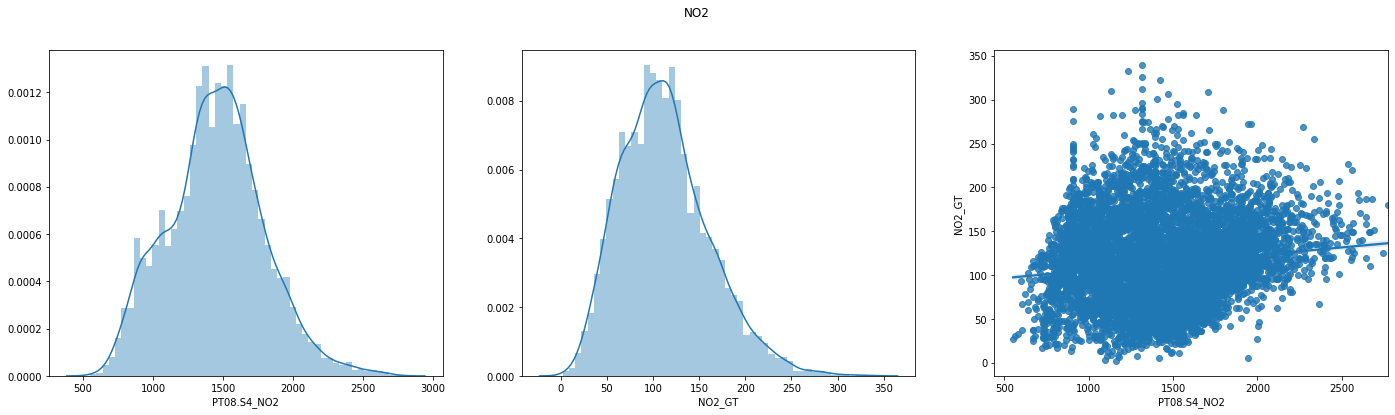

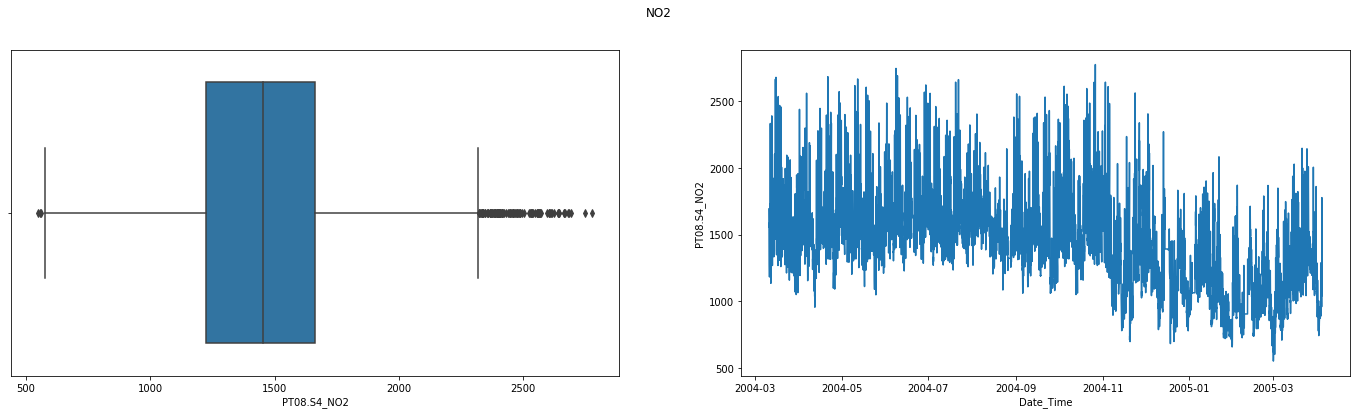

In [15]:
# NO2 data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle('NO2')
sns.distplot(df['PT08.S4_NO2'], norm_hist=False, kde=True, ax=ax1) 
sns.distplot(df['NO2_GT'], norm_hist=False, kde=True, ax=ax2)   
sns.regplot(x="PT08.S4_NO2", y="NO2_GT", data=df, ax=ax3)
#ax3.set(xscale='log', yscale='log')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
fig.suptitle('NO2')
sns.boxplot(x="PT08.S4_NO2", data=df, ax=ax1)
sns.lineplot(x=df.index, y="PT08.S4_NO2", data=df, ax=ax2)

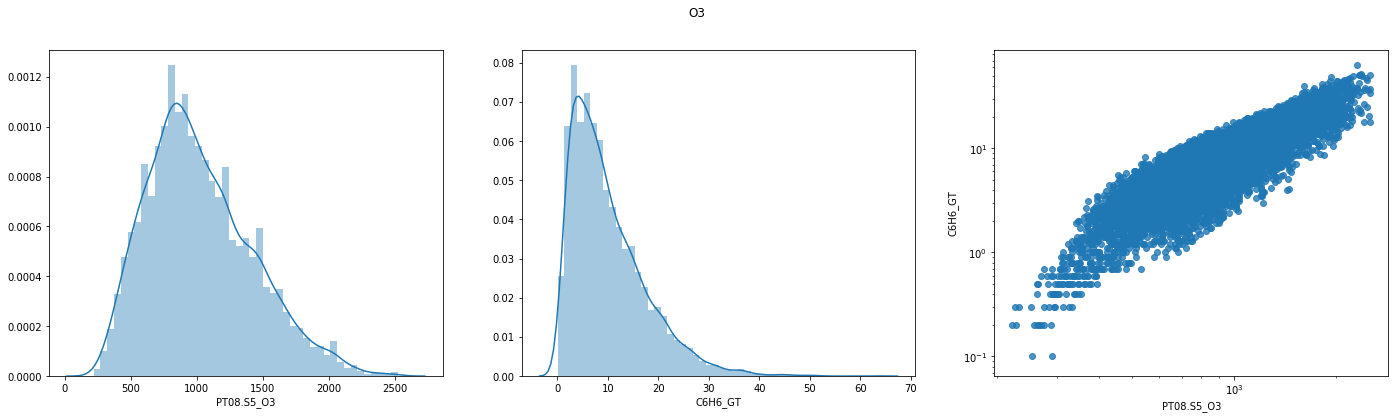

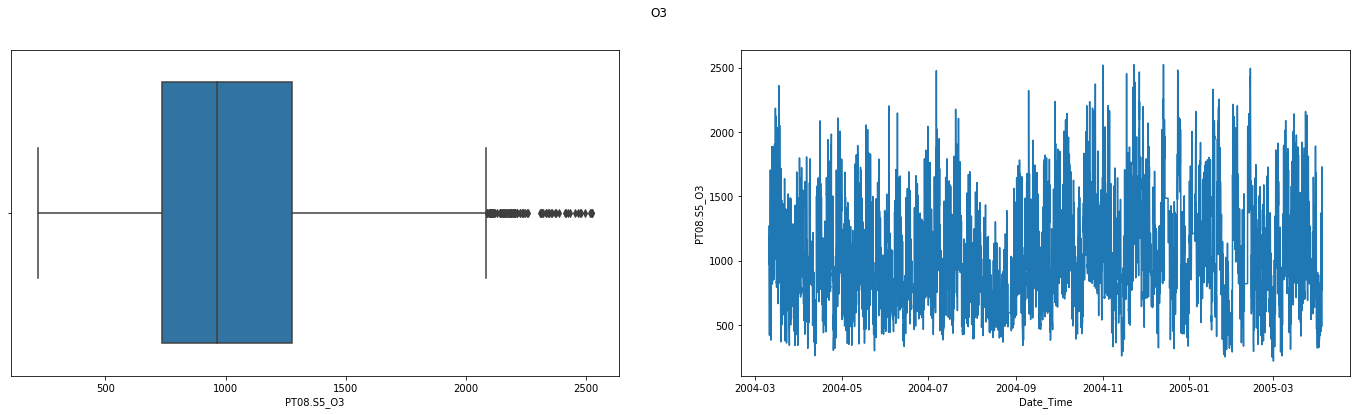

In [17]:
# O3 data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle('O3')
sns.distplot(df['PT08.S5_O3'], norm_hist=False, kde=True, ax=ax1) 
sns.distplot(df['C6H6_GT'], norm_hist=False, kde=True, ax=ax2)  
sns.regplot(x="PT08.S5_O3", y="C6H6_GT", fit_reg=False, data=df, ax=ax3)
ax3.set(xscale='log', yscale='log')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
fig.suptitle('O3')
sns.boxplot(x="PT08.S5_O3", data=df, ax=ax1)
sns.lineplot(x=df.index, y="PT08.S5_O3", data=df, ax=ax2)

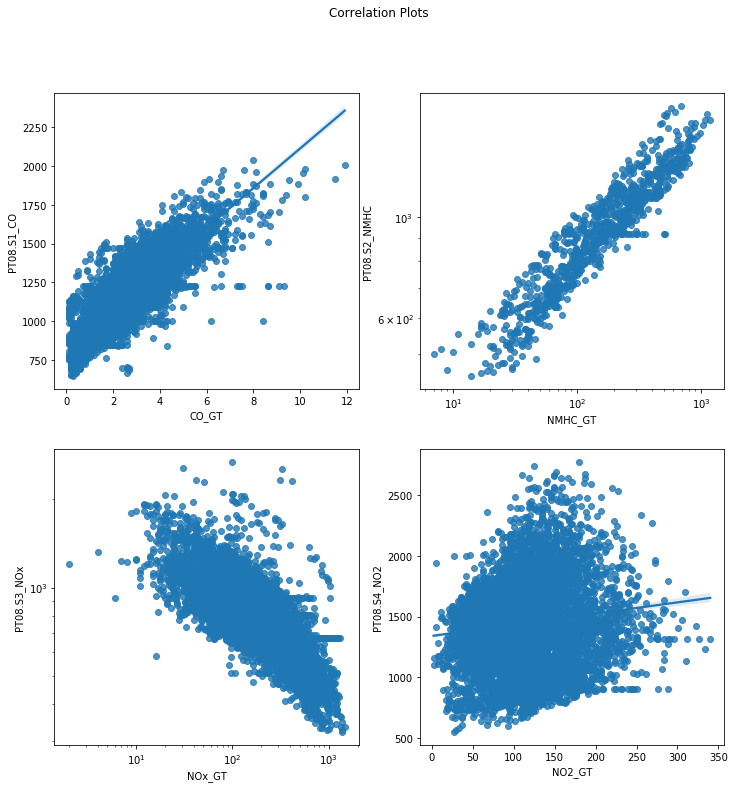

In [20]:
# Feature-Target Correlation plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(12, 12)
fig.suptitle('Correlation Plots')

sns.regplot(x="CO_GT", y="PT08.S1_CO", data=df, ax=ax1)

sns.regplot(x="NMHC_GT", y="PT08.S2_NMHC", data=df, ax=ax2, fit_reg=False)
ax2.set(xscale='log', yscale='log')

sns.regplot(x="NOx_GT", y="PT08.S3_NOx", data=df, ax=ax3, fit_reg=False)
ax3.set(xscale='log', yscale='log')

sns.regplot(x="NO2_GT", y="PT08.S4_NO2", data=df, ax=ax4)

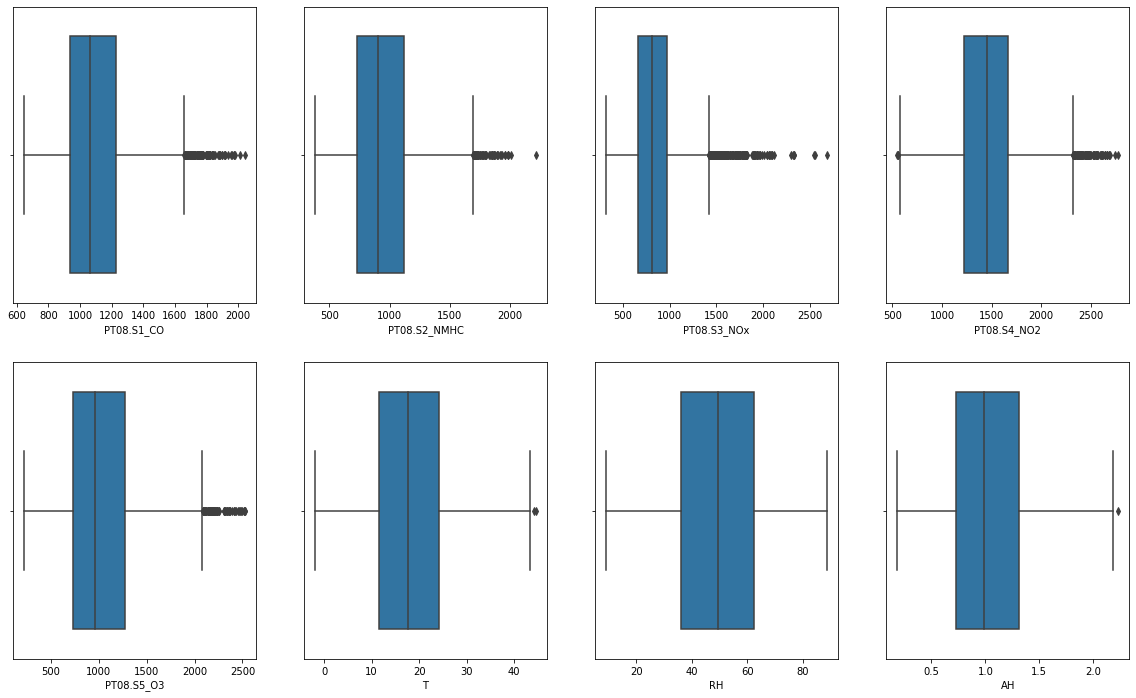

In [21]:
#Box plots for all features
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4)
fig.set_size_inches(20, 12)
sns.boxplot(x="PT08.S1_CO", data=df, ax=ax1)
sns.boxplot(x="PT08.S2_NMHC", data=df, ax=ax2)
sns.boxplot(x="PT08.S3_NOx", data=df, ax=ax3)
sns.boxplot(x="PT08.S4_NO2", data=df, ax=ax4)
sns.boxplot(x="PT08.S5_O3", data=df, ax=ax5)
sns.boxplot(x="T", data=df, ax=ax6)
sns.boxplot(x="RH", data=df, ax=ax7)
sns.boxplot(x="AH", data=df, ax=ax8)

In [32]:
# Group data by Day of the week 
df['DOW']  = df.index
df_dow = df.groupby(df['DOW'].dt.weekday).mean()
df_dow['Day'] = pd.to_numeric(df_dow.index).map({0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thr', 4: 'Fri', 5: 'Sat', 6: 'Sun'})

# Reorder columns
cols = df_dow.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_dow = df_dow[cols]

# Reset index
df_dow = df_dow.reset_index(drop=True)

# Set index
df_dow = df_dow.set_index('Day')
df_dow.reindex(['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun'])

df_dow


,CO_GT,PT08.S1_CO,NMHC_GT,C6H6_GT,PT08.S2_NMHC,NOx_GT,PT08.S3_NOx,NO2_GT,PT08.S4_NO2,PT08.S5_O3,T,RH,AH
Day,,,,,,,,,,,,,
Mon,2.016741,1069.635334,180.110169,9.955641,925.136886,234.927872,858.862343,110.297683,1427.896351,980.614767,17.864437,47.744092,0.978723
Tue,2.382267,1115.669400,233.583333,11.680016,983.902237,267.667921,812.520884,117.393227,1492.385662,1083.136427,18.032874,48.703938,0.999615
Wed,2.400787,1127.953612,219.561151,11.400000,988.774594,270.430712,811.273605,120.007491,1495.644646,1107.768345,18.367902,49.630850,1.029290
Thr,2.455505,1135.592060,278.800000,11.526688,984.590729,282.604817,801.848435,120.843889,1503.271962,1103.809213,18.336667,50.074193,1.043231
Fri,2.543041,1145.264082,287.302469,11.729791,995.032453,284.506098,785.710742,123.452007,1514.871377,1115.917376,18.374307,50.786310,1.054830
Sat,1.861077,1088.358996,164.563636,8.507154,896.623835,224.491892,837.788856,107.567568,1398.554037,979.573932,18.268107,48.877326,1.014690
Sun,1.438069,1016.224490,99.114583,6.050873,792.767751,162.004608,939.069196,91.655300,1318.268601,816.564307,17.926276,49.185204,1.007587


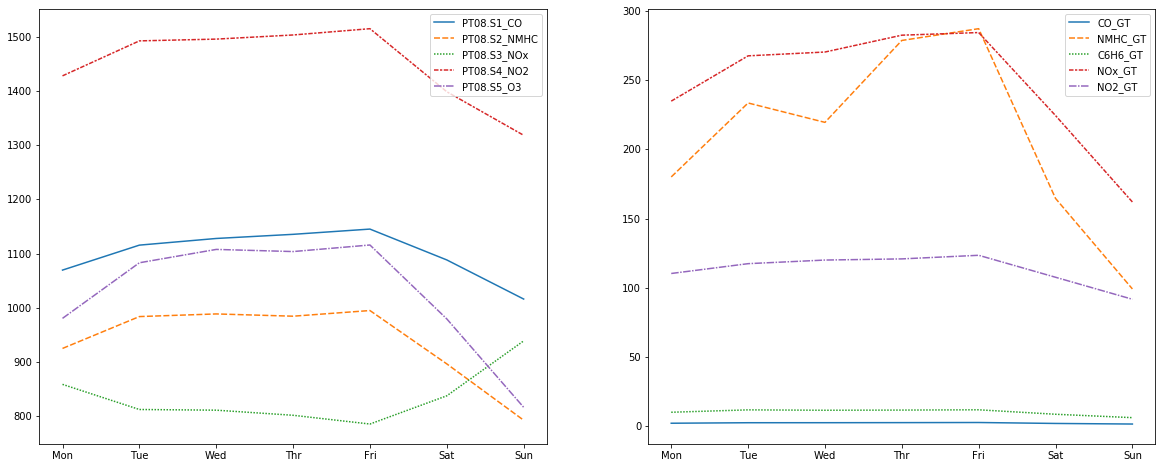

In [69]:
# Plot data averaged by data of the week
dow_features = [df_dow["PT08.S1_CO"], df_dow["PT08.S2_NMHC"], df_dow["PT08.S3_NOx"], df_dow["PT08.S4_NO2"], df_dow["PT08.S5_O3"]]
dow_targets = [df_dow["CO_GT"], df_dow["NMHC_GT"], df_dow["C6H6_GT"], df_dow["NOx_GT"], df_dow["NO2_GT"]]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

sns.lineplot(data=dow_features, sort=False , ax=ax1)
sns.lineplot(data=dow_targets, sort=False , ax=ax2)

In [68]:
# Group data by Month of the year
df['MOY']  = df.index
df_moy = df.groupby(df['MOY'].dt.month).mean()
df_moy['Mon'] = pd.to_numeric(df_moy.index).map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})

# Reorder columns
cols = df_moy.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_moy = df_moy[cols]

# Reset index
df_moy = df_moy.reset_index(drop=True)

# Set index
df_moy = df_moy.set_index('Mon')
df_moy.reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

df_moy

,CO_GT,PT08.S1_CO,NMHC_GT,C6H6_GT,PT08.S2_NMHC,NOx_GT,PT08.S3_NOx,NO2_GT,PT08.S4_NO2,PT08.S5_O3,T,RH,AH
Mon,,,,,,,,,,,,,
Jan,2.135059,1107.586863,NaN,9.024597,883.327012,349.819718,795.947678,134.781690,1144.193412,1100.452740,8.059318,56.669222,0.628082
Feb,2.096229,1092.433999,NaN,7.500839,841.416842,315.043614,794.011817,160.694704,1053.116334,1046.639093,7.275385,50.840319,0.509445
Mar,2.144079,1176.856667,171.604423,9.219393,907.325567,243.184275,839.424346,123.285831,1366.334269,1060.944872,13.693749,50.603245,0.784695
Apr,2.142931,1140.974370,256.671937,9.708333,921.596981,145.638743,929.505361,98.710297,1541.028193,970.395137,16.641211,49.556990,0.888945
May,1.940034,1076.390379,275.000000,10.219041,953.898514,122.132107,949.721562,93.148829,1598.316016,930.914672,20.380357,43.127596,0.951497
Jun,1.900000,1017.944286,NaN,10.595748,960.692540,122.064715,901.322143,94.084877,1717.431587,930.368095,26.455643,39.959782,1.279043
Jul,1.784946,1046.428062,NaN,10.599462,971.433205,126.754213,804.839411,104.120956,1643.843268,994.281265,29.421371,33.061068,1.243150
Aug,1.280084,973.420891,NaN,6.993669,829.441590,75.868526,845.350614,70.097804,1566.434370,767.732488,28.813694,43.138237,1.602096
Sep,2.164209,1085.646920,NaN,11.554558,999.929995,280.572072,812.100155,108.047297,1544.426777,1046.348499,24.685645,43.584742,1.277470


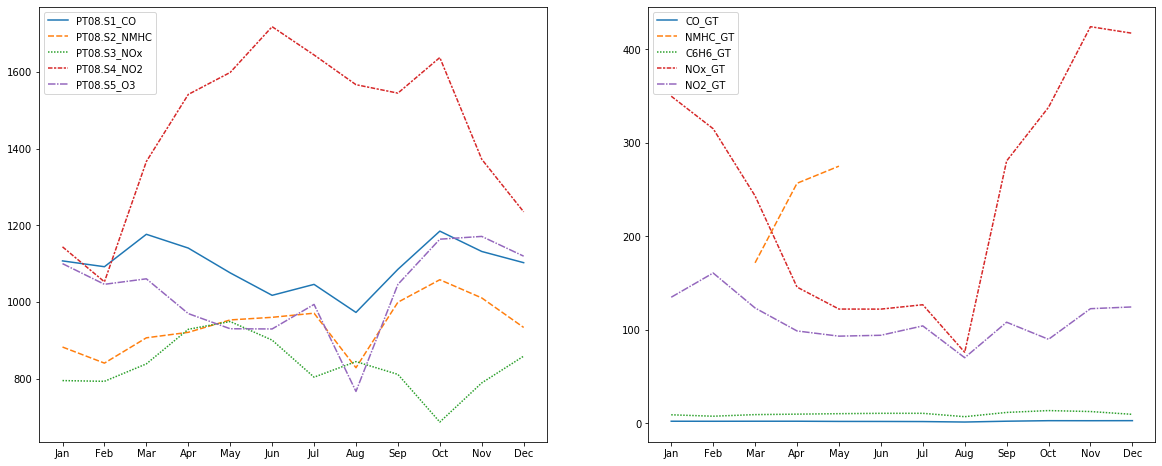

In [71]:
# Plot data averaged by month of the year
moy_features = [df_moy["PT08.S1_CO"], df_moy["PT08.S2_NMHC"], df_moy["PT08.S3_NOx"], df_moy["PT08.S4_NO2"], df_moy["PT08.S5_O3"]]
moy_targets = [df_moy["CO_GT"], df_moy["NMHC_GT"], df_moy["C6H6_GT"], df_moy["NOx_GT"], df_moy["NO2_GT"]]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

sns.lineplot(data=moy_features, sort=False , ax=ax1)
sns.lineplot(data=moy_targets, sort=False , ax=ax2)